In [1]:
# Installing required libraries
!pip install yFinance statsmodels matplotlib pandas

In [2]:
# Importing important libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Getting the data
gold_data = yf.download('GC=F', start = "2000-01-01", end = "2025-07-19", interval = "1mo")
gold_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2000-08-01,278.299988,278.299988,273.899994,273.899994,0
2000-09-01,273.600006,278.399994,269.000000,277.000000,4291
2000-11-01,270.100006,270.200012,263.899994,263.899994,32465
2000-12-01,272.000000,276.000000,268.000000,269.700012,1664
2001-01-01,265.600006,268.399994,262.799988,268.399994,17811


In [4]:
# Keep only closing price and remove missing values
gold = gold_data[['Close']].copy()
gold.columns = ['Price']
gold.dropna(inplace = True)
gold.head()

,Price
Date,
2000-08-01,278.299988
2000-09-01,273.600006
2000-11-01,270.100006
2000-12-01,272.000000
2001-01-01,265.600006


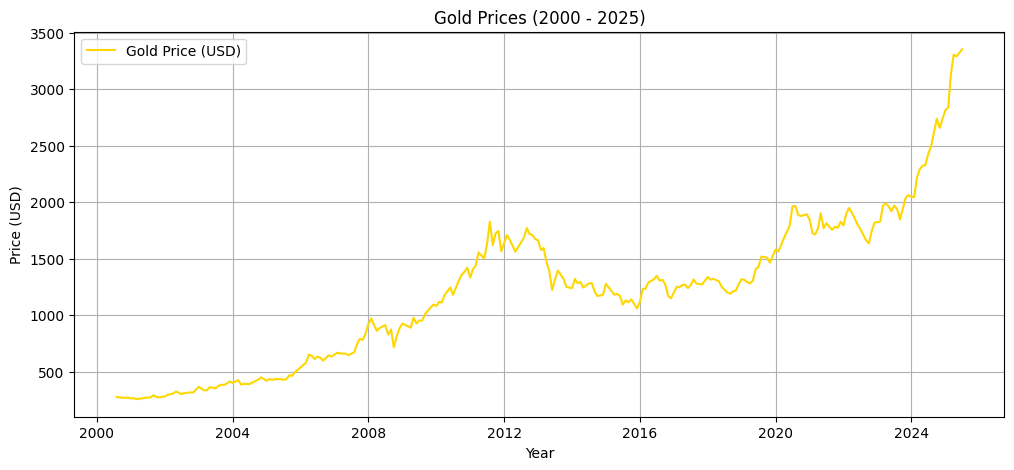

In [5]:
# Plot
plt.figure(figsize = (12, 5))
plt.plot(gold, label = 'Gold Price (USD)', color ='gold')
plt.title('Gold Prices (2000 - 2025)')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

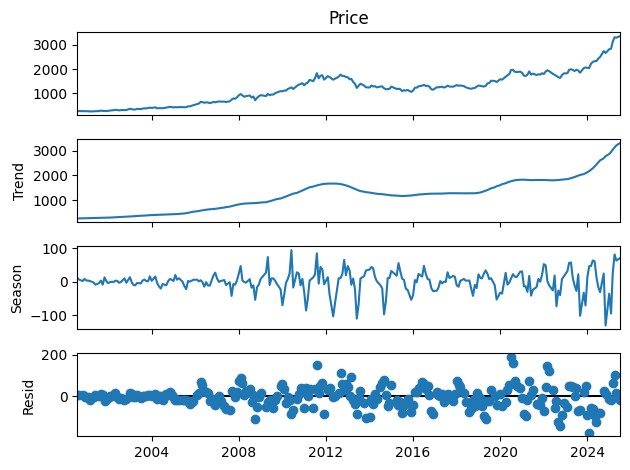

In [6]:
# STL Decompostion
stl = STL(gold['Price'], period = 12)
result = stl.fit()
result.plot()
plt.show()

In [7]:
# ADF Test for Stationarity
adf_result = adfuller(gold['Price'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
if adf_result[1] <= 0.05:
    print('\nThe series is stationary.')
else:
    print('\nThe series is not stationary.')

ADF Statistic: 0.9845601478572097
p-value: 0.9941003391349512

The series is not stationary.


In [ ]:
'''
Since, the data that we are working with is not stationary,
hence we cannot use AR, MA and ARMA models.
'''

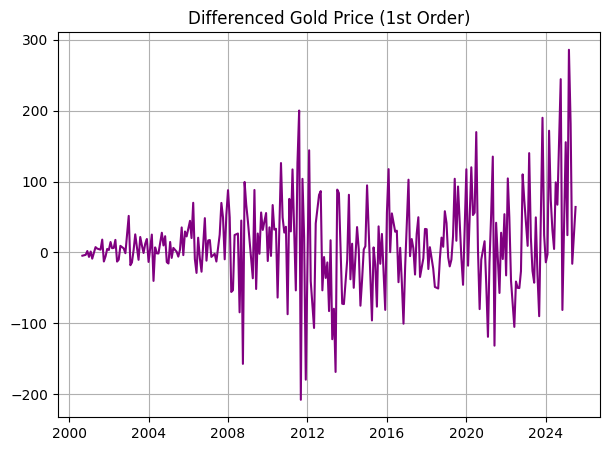

In [8]:
# Differencing to make series stationary
gold_diff = gold['Price'].diff().dropna()

plt.figure(figsize = (7, 5))
plt.plot(gold_diff, label = 'Gold Price (USD)', color = 'Purple')
plt.title('Differenced Gold Price (1st Order)')
plt.grid(True)
plt.show()

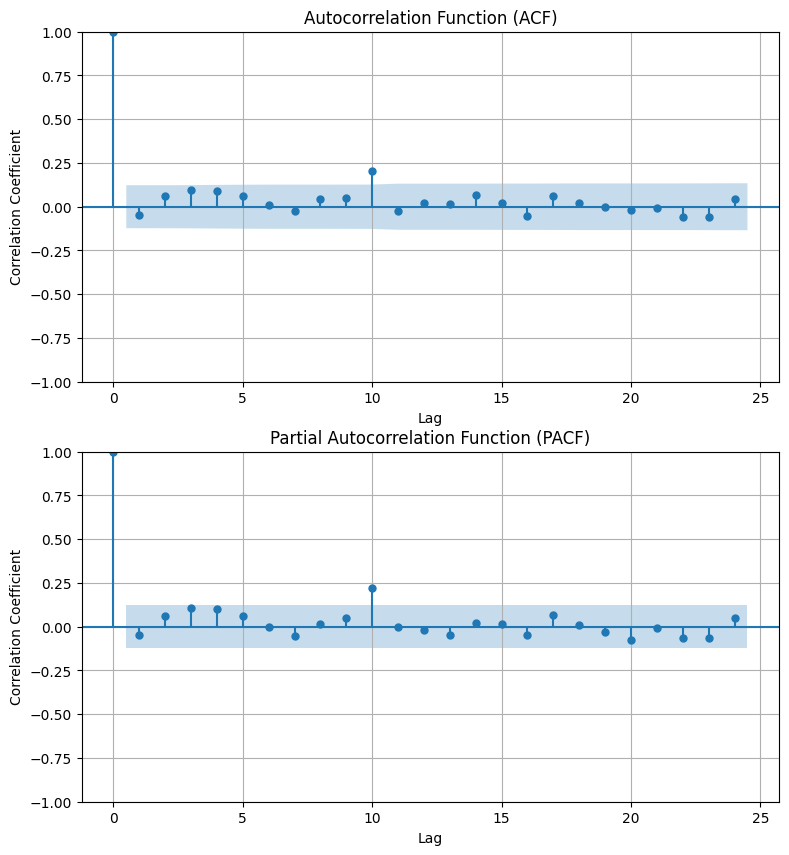

In [9]:
# ACF and PACF Plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (9, 10))

# ACF Plot
plot_acf(gold_diff, ax = ax1, lags = 24, alpha = 0.05)
ax1.set_title('Autocorrelation Function (ACF)')
ax1.set_ylabel('Correlation Coefficient')
ax1.set_xlabel('Lag')
ax1.grid(True)

# PACF Plot
plot_pacf(gold_diff, ax = ax2, lags = 24, alpha = 0.05)
ax2.set_title('Partial Autocorrelation Function (PACF)')
ax2.set_ylabel('Correlation Coefficient')
ax2.set_xlabel('Lag')
ax2.grid(True)

plt.show()

In [ ]:
'''
Conclusions ->
(1) Significant spike are seen at lag 10
(2) PACF cuts after lag (p = 1)
(3) ACF cuts after lag (q = 1)
'''

In [10]:
# Fitting the ARIMA Model (Basic)
model_arima = ARIMA(gold['Price'], order = (1, 1, 1))
model_arima_fit = model_arima.fit()
print('\nARIMA Model Summary :\n')
print(model_arima_fit.summary())


ARIMA Model Summary :

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  256
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1431.390
Date:                Sun, 20 Jul 2025   AIC                           2868.781
Time:                        14:13:17   BIC                           2879.405
Sample:                             0   HQIC                          2873.054
                                - 256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9801      0.070    -13.999      0.000      -1.117      -0.843
ma.L1          0.9633      0.087     11.109      0.000       0.793       1.133
sigma2      4395.3909    290

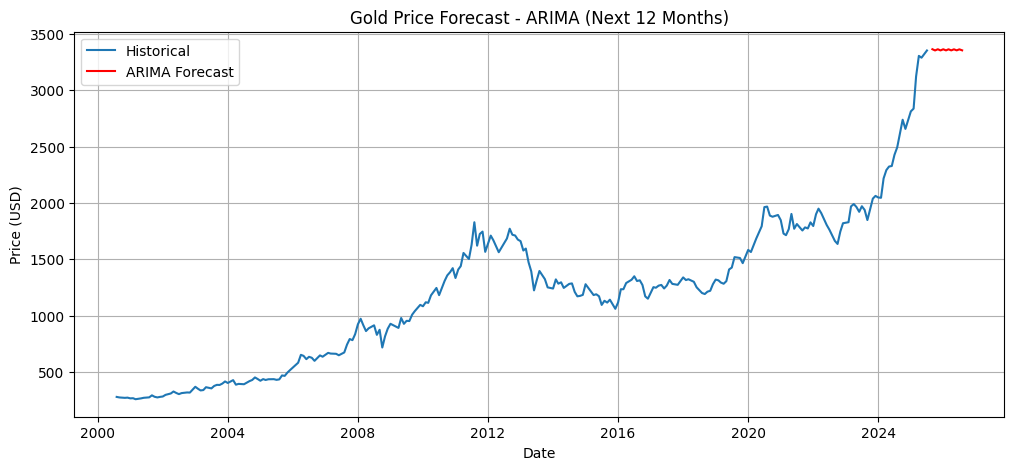

In [11]:
# Forecasting using ARIMA
forecast_arima = model_arima_fit.forecast(steps = 12)
forecast_index = pd.date_range(start = gold.index[-1] + pd.DateOffset(months = 1), periods =  12, freq = 'M')

# Plot
plt.figure(figsize = (12, 5))
plt.plot(gold['Price'], label = 'Historical')
plt.plot(forecast_index, forecast_arima, label = 'ARIMA Forecast', color = 'red')
plt.title('Gold Price Forecast - ARIMA (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# SARIMA
model_sarima = SARIMAX(gold['Price'], order = (1, 1, 1), seasonal_order = (1, 1, 1, 10))
model_sarima_fit = model_sarima.fit()
print('\nSARIMA Model Summary :\n')
print(model_sarima_fit.summary())


SARIMA Model Summary :

                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  256
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 10)   Log Likelihood               -1376.374
Date:                            Sun, 20 Jul 2025   AIC                           2762.748
Time:                                    14:13:47   BIC                           2780.254
Sample:                                         0   HQIC                          2769.797
                                            - 256                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2127      1.090     -0.195      0.845      -2.349       1.924
ma.L1     

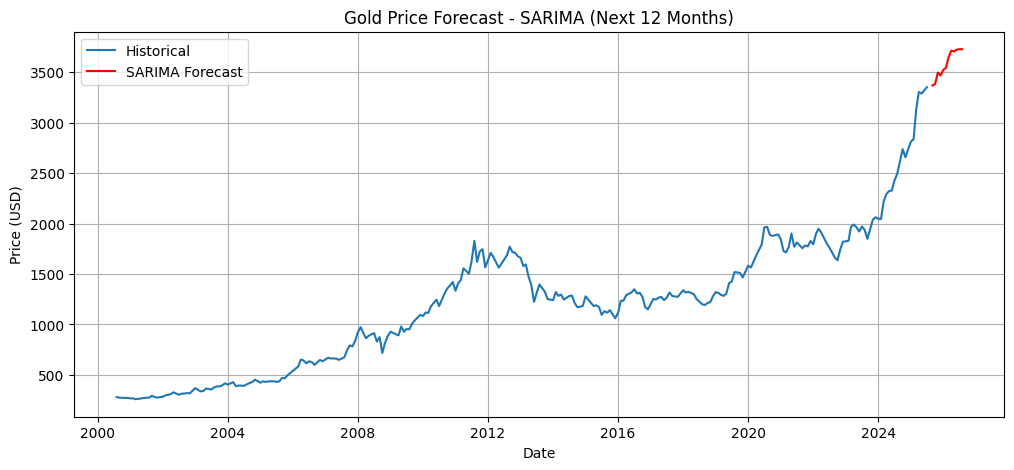

In [13]:
# Forecasting using SARIMA
forecast_sarima = model_sarima_fit.forecast(steps = 12)
forecast_index = pd.date_range(start = gold.index[-1] + pd.DateOffset(months = 1), periods = 12, freq = 'M')

# Plot
plt.figure(figsize = (12, 5))
plt.plot(gold['Price'], label = 'Historical')
plt.plot(forecast_index, forecast_sarima, label = 'SARIMA Forecast', color = 'red')
plt.title('Gold Price Forecast - SARIMA (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Model Comparison
print("Model Comparison :")
print(f"ARIMA Model AIC: {model_arima_fit.aic}")
print(f"SARIMA Model AIC: {model_sarima_fit.aic}")

# Select model based on lesser AIC
if model_arima_fit.aic < model_sarima_fit.aic:
    print("\nARIMA model is selected.")
else:
    print("\nSARIMA model is selected.")

Model Comparison :
ARIMA Model AIC: 2868.780816161292
SARIMA Model AIC: 2762.74759906298

SARIMA model is selected.


In [15]:
# Saving the model in pickle file format
import pickle
with open('sarima_gold_model_2000_2025.pkl', 'wb') as file:
    pickle.dump(model_sarima_fit, file)

In [16]:
# Saving the model in pickle file format
import pickle
with open('arima_gold_model_2000_2025.pkl', 'wb') as file:
    pickle.dump(model_arima_fit, file)